# **Análise Preditiva dos Fatores que Influenciam o Peso de Recém-Nascidos**

## Importação das bibliotecas

In [3]:
# Instalações (se necessárias)
!pip install basedosdados
!pip install statsmodels
!pip install scipy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pylab
!pip install pandas
!pip install numpy
!pip install warnings

# Import da fonte dos dados
import basedosdados as bd

# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Imports para modelagem estatística
import pylab
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.regression.linear_model as smf
import statsmodels.stats.api as sms
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# Import para divisão dos dados
import sklearn
from sklearn.model_selection import train_test_split

# Import para padronização dos dados
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)
ERROR: No matching distribution found for pylab
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


## Extração dos dados
*A seguir, os dados são extraídos diretamente do datalake público da Base dos Dados, filtrando-se pelos nascimentos ocorridos de janeiro de 2023 até novembro de 2023 (data da última atualização).*

In [4]:
# Define o ID do projeto de faturamento do Google Cloud
billing_id = "projeto-dsa-460815"

# Query para selecionar os dados de interesse do SINASC
query = """
  SELECT
    dados.sequencial_nascimento as sequencial_nascimento,
    dados.data_nascimento as data_nascimento,
    dados.peso as peso,
    dados.apgar1 as apgar1,
    dados.apgar5 as apgar5,
    dados.semana_gestacao as semana_gestacao,
    dados.pre_natal as pre_natal,
    dados.quantidade_filhos_vivos as quantidade_filhos_vivos,
    dados.quantidade_filhos_mortos as quantidade_filhos_mortos,
    dados.idade_mae as idade_mae,
    dados.gestacoes_ant as gestacoes_ant,
    dados.quantidade_parto_normal as quantidade_parto_normal,
    dados.quantidade_parto_cesareo as quantidade_parto_cesareo
FROM `basedosdados.br_ms_sinasc.microdados` AS dados
WHERE data_nascimento >= "2023-01-01"
"""

# Leitura dos dados utilizando a biblioteca basedosdados
df = bd.read_sql(query = query, billing_project_id = billing_id)

Downloading: 100%|██████████|


## Preparação dos Dados

In [5]:
# Cópia de base de dados para eventuais ajustes ou alterações
dados = df.copy()

In [6]:
# Visualização inicial da estrutura dos dados
dados.head(10)

,sequencial_nascimento,data_nascimento,peso,apgar1,apgar5,semana_gestacao,pre_natal,quantidade_filhos_vivos,quantidade_filhos_mortos,idade_mae,gestacoes_ant,quantidade_parto_normal,quantidade_parto_cesareo
0,342482,2023-02-27,3820,<NA>,<NA>,40,9,0,0,21,0,0,0
1,317436,2023-04-06,1995,8,9,36,<NA>,0,0,19,<NA>,<NA>,<NA>
2,36332,2023-02-19,3500,<NA>,<NA>,38,7,0,0,15,0,0,0
3,173864,2023-01-30,2435,<NA>,<NA>,37,<NA>,<NA>,<NA>,37,<NA>,<NA>,<NA>
4,44117,2023-04-02,3600,<NA>,<NA>,36,4,0,0,17,0,0,0
5,923138,2023-02-26,2495,9,9,37,4,0,0,21,0,0,0
6,16158,2023-01-17,3500,8,10,38,7,0,0,14,0,0,0
7,36865,2023-02-05,3372,8,9,39,7,0,0,22,0,0,0
8,70809,2023-01-10,3300,<NA>,<NA>,38,2,0,0,17,0,0,0
9,37797,2023-04-05,3980,<NA>,<NA>,35,7,0,0,23,0,0,0


In [7]:
# Exclusão das colunas que não serão utilizadas
colunas_excluir = ["sequencial_nascimento", "data_nascimento"]
dados = dados.drop(colunas_excluir, axis=1)

## Tratamento de valores ausentes

In [8]:
dados.count()

,0
peso,986510
apgar1,977040
apgar5,977063
semana_gestacao,977093
pre_natal,972016
quantidade_filhos_vivos,970437
quantidade_filhos_mortos,963460
idade_mae,986585
gestacoes_ant,967627
quantidade_parto_normal,963119


As diferentes quantidades para cada variável indicam valores ausentes no dataset

In [9]:
# Quantidade de valores ausentes
valores_ausentes = dados.isnull().sum().sort_values(ascending = False)

# Cria um resumo % com os valores ausentes
df_valores_ausentes = pd.DataFrame({'valores_ausentes': valores_ausentes, 'Percentual': (valores_ausentes / len(dados)) * 100})

# Resultado com os valores maior que zero
df_valores_ausentes[df_valores_ausentes['valores_ausentes'] > 0]

,valores_ausentes,Percentual
quantidade_parto_cesareo,25702,2.605132
quantidade_parto_normal,23472,2.379101
quantidade_filhos_mortos,23131,2.344538
gestacoes_ant,18964,1.922174
quantidade_filhos_vivos,16154,1.637355
pre_natal,14575,1.477309
apgar1,9551,0.968081
apgar5,9528,0.965750
semana_gestacao,9498,0.962709
peso,81,0.008210


Após a análise inicial, foi identificado que a maior perda de dados, na coluna **quantidade_parto_cesareo**, seria de aproximadamente **2.6%**. Como essa porcentagem é baixa, a estratégia de remoção completa das linhas com valores ausentes (**dropna()**) foi a escolhida. Esta abordagem é simples, eficaz e evita a introdução de um possível viés que poderia surgir ao tentar "adivinhar" (imputar) os dados faltantes.

In [10]:
# Remoção das linhas em branco
dados = dados.dropna()

In [11]:
# Verificando novamente os dados ausentes
valores_ausentes = dados.isnull().sum().sort_values(ascending = False)
print(valores_ausentes)

peso                        0
apgar1                      0
apgar5                      0
semana_gestacao             0
pre_natal                   0
quantidade_filhos_vivos     0
quantidade_filhos_mortos    0
idade_mae                   0
gestacoes_ant               0
quantidade_parto_normal     0
quantidade_parto_cesareo    0
dtype: int64


## Análise exploratória

In [12]:
dados.describe()

,peso,apgar1,apgar5,semana_gestacao,pre_natal,quantidade_filhos_vivos,quantidade_filhos_mortos,idade_mae,gestacoes_ant,quantidade_parto_normal,quantidade_parto_cesareo
count,930920.0,930920.0,930920.0,930920.0,930920.0,930920.0,930920.0,930920.0,930920.0,930920.0,930920.0
mean,3153.878124,8.408047,9.357632,38.239851,8.965528,1.008999,0.27431,27.670044,1.258802,0.635697,0.41197
std,557.822198,2.788375,2.306519,2.2056,5.885285,1.464022,1.165202,6.700296,1.595691,1.49217,1.182045
min,100.0,0.0,0.0,19.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
25%,2878.0,8.0,9.0,38.0,7.0,0.0,0.0,22.0,0.0,0.0,0.0
50%,3195.0,9.0,9.0,39.0,9.0,1.0,0.0,27.0,1.0,0.0,0.0
75%,3500.0,9.0,10.0,39.0,10.0,2.0,0.0,33.0,2.0,1.0,1.0
max,7000.0,99.0,99.0,45.0,99.0,99.0,99.0,65.0,99.0,99.0,99.0


A função **describe()** revelou que diversas variáveis possuem o valor máximo de 99 (ex: **pre_natal**, **gestacoes_ant**). Este é um padrão comum em datasets públicos, onde 99 é frequentemente utilizado como um código para "ignorado" ou "não informado". Como esses valores não representam uma contagem real, as linhas que os contêm foram removidas para garantir a qualidade do modelo.

In [13]:
colunas_para_verificar = [
    'apgar1',
    'apgar5',
    'pre_natal',
    'quantidade_filhos_vivos',
    'quantidade_filhos_mortos',
    'gestacoes_ant',
    'quantidade_parto_normal',
    'quantidade_parto_cesareo'
]

# Quantidade de valores 99
valores_99 = dados[dados[colunas_para_verificar] == 99].count().sort_index()

# Cria um resumo % com os valores 99
df_valores_99 = pd.DataFrame({'valores_99': valores_99, 'Percentual': (valores_99 / len(dados)) * 100})

# Resultado com os valores maior que zero
df_valores_99[df_valores_99['valores_99'] > 0]

,valores_99,Percentual
apgar1,721,0.077450
apgar5,529,0.056826
gestacoes_ant,51,0.005478
pre_natal,2782,0.298844
quantidade_filhos_mortos,95,0.010205
quantidade_filhos_vivos,65,0.006982
quantidade_parto_cesareo,82,0.008808
quantidade_parto_normal,82,0.008808


Os valores com o preenchimento 99 serão excluídos por terem baixa representatividade nos valores totais

In [14]:
colunas_para_verificar = [
    'apgar1',
    'apgar5',
    'pre_natal',
    'quantidade_filhos_vivos',
    'quantidade_filhos_mortos',
    'gestacoes_ant',
    'quantidade_parto_normal',
    'quantidade_parto_cesareo'
]

print(f"Tamanho ANTES da remoção múltipla: {dados.shape}")

for coluna in colunas_para_verificar:
    if coluna in dados.columns:
        print(f"Verificando coluna: {coluna}...")
        linhas_antes = dados.shape[0]
        dados = dados[dados[coluna] != 99]
        linhas_depois = dados.shape[0]
        print(f"  -> Removidas {linhas_antes - linhas_depois} linhas com 99.")
    else:
        print(f"Atenção: A coluna '{coluna}' não foi encontrada no DataFrame.")


print(f"\nTamanho DEPOIS da remoção múltipla: {dados.shape}")

Tamanho ANTES da remoção múltipla: (930920, 11)
Verificando coluna: apgar1...
  -> Removidas 721 linhas com 99.
Verificando coluna: apgar5...
  -> Removidas 12 linhas com 99.
Verificando coluna: pre_natal...
  -> Removidas 2741 linhas com 99.
Verificando coluna: quantidade_filhos_vivos...
  -> Removidas 65 linhas com 99.
Verificando coluna: quantidade_filhos_mortos...
  -> Removidas 38 linhas com 99.
Verificando coluna: gestacoes_ant...
  -> Removidas 0 linhas com 99.
Verificando coluna: quantidade_parto_normal...
  -> Removidas 8 linhas com 99.
Verificando coluna: quantidade_parto_cesareo...
  -> Removidas 2 linhas com 99.

Tamanho DEPOIS da remoção múltipla: (927333, 11)


In [15]:
# Nova visualização dos dados
dados.describe()

,peso,apgar1,apgar5,semana_gestacao,pre_natal,quantidade_filhos_vivos,quantidade_filhos_mortos,idade_mae,gestacoes_ant,quantidade_parto_normal,quantidade_parto_cesareo
count,927333.0,927333.0,927333.0,927333.0,927333.0,927333.0,927333.0,927333.0,927333.0,927333.0,927333.0
mean,3154.7477,8.338684,9.30768,38.242647,8.697026,1.000152,0.264175,27.671332,1.251424,0.624794,0.403434
std,556.955965,1.187784,0.864633,2.200125,3.219524,1.211321,0.602412,6.699754,1.420261,1.168136,0.735579
min,100.0,0.0,0.0,19.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
25%,2880.0,8.0,9.0,38.0,7.0,0.0,0.0,22.0,0.0,0.0,0.0
50%,3195.0,9.0,9.0,39.0,9.0,1.0,0.0,27.0,1.0,0.0,0.0
75%,3500.0,9.0,10.0,39.0,10.0,2.0,0.0,33.0,2.0,1.0,1.0
max,7000.0,10.0,10.0,45.0,66.0,30.0,25.0,65.0,26.0,97.0,91.0


Os valores máximos para "quantidade_parto_normal" e "quantidade_parto_cesario" ainda chamam atenção e podem ser considerados outliers. Existem estudos do IBGE que apontam a taxa de fencundidade no Brasil em **1,57 filhos por mulher** reforçando a tese de que os valores para estas variáveis são possíveis outliers.

Será avaliado a quantidade de observações acima de 15 partos (número considerado pelo autor) para exclusão.

In [16]:
dados_normal_cesareo = dados.copy()

# Definir um limite do que você considera 'impossível' ou 'muito improvável'
# Por exemplo, vamos considerar que mais de, digamos, 15 partos já é suspeito.
limite_partos = 15

# Contar quantas linhas têm esses valores extremos
altos_normal = dados_normal_cesareo[dados_normal_cesareo['quantidade_parto_normal'] > limite_partos].shape[0]
altos_cesareo = dados_normal_cesareo[dados_normal_cesareo['quantidade_parto_cesareo'] > limite_partos].shape[0]

print(f"\nNúmero de linhas com mais de {limite_partos} partos normais: {altos_normal}")
print(f"Número de linhas com mais de {limite_partos} partos cesáreos: {altos_cesareo}")


Número de linhas com mais de 15 partos normais: 50
Número de linhas com mais de 15 partos cesáreos: 55


As observações serão exlcuídas dada a baixa quantidade de partos normais e cesáreos acima de 15.

In [17]:
dados = dados[dados["quantidade_parto_normal"] <= limite_partos]
dados = dados[dados["quantidade_parto_cesareo"] <= limite_partos]

In [19]:
# Nova visualização dos dados com os ajutes em "quantidade_parto_normal" e "quantidade_parto_cesario"
dados.describe()

,peso,apgar1,apgar5,semana_gestacao,pre_natal,quantidade_filhos_vivos,quantidade_filhos_mortos,idade_mae,gestacoes_ant,quantidade_parto_normal,quantidade_parto_cesareo
count,927229.0,927229.0,927229.0,927229.0,927229.0,927229.0,927229.0,927229.0,927229.0,927229.0,927229.0
mean,3154.75472,8.338698,9.307695,38.242723,8.697117,0.999943,0.264139,27.670955,1.251219,0.623231,0.401904
std,556.940061,1.187752,0.864596,2.200052,3.219513,1.21075,0.60231,6.699677,1.419746,1.141855,0.702635
min,100.0,0.0,0.0,19.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
25%,2880.0,8.0,9.0,38.0,7.0,0.0,0.0,22.0,0.0,0.0,0.0
50%,3195.0,9.0,9.0,39.0,9.0,1.0,0.0,27.0,1.0,0.0,0.0
75%,3500.0,9.0,10.0,39.0,10.0,2.0,0.0,33.0,2.0,1.0,1.0
max,7000.0,10.0,10.0,45.0,66.0,30.0,25.0,65.0,26.0,15.0,14.0


# **Peso**
A partir deste momento, a análise será focada nos fatores que podem influenciar o **Peso** do recém-nascido.

In [20]:
# Exclusão da variável apgar5 e apgar1. Estas variáveis não serão utilizadas neste estudo
dados_peso = dados.drop(columns= {"apgar5", "apgar1"})

## Analisando a distribuição do Peso (variável alvo)

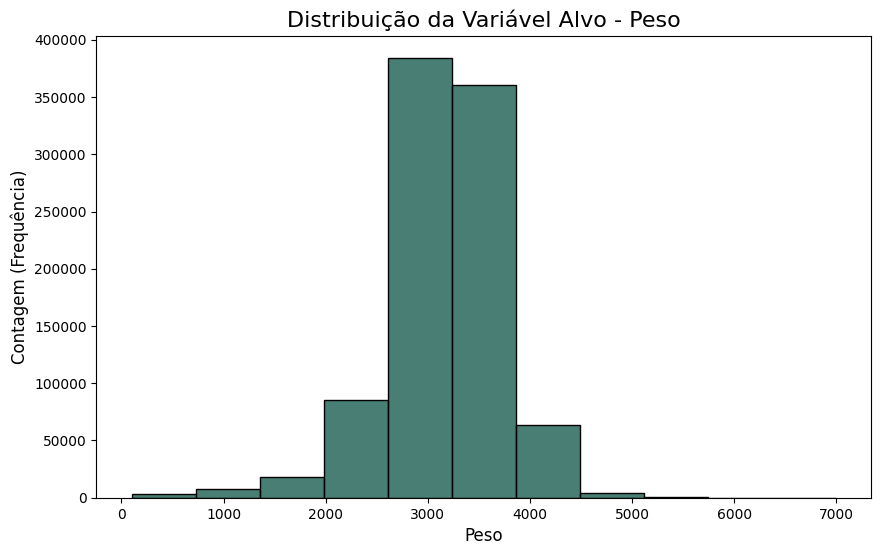

In [30]:
# Configurando o gráfico de histograma
plt.figure(figsize=(10, 6))

sns.histplot(data=dados_peso, x='peso', kde=False, bins=11, color='#0B5345')

plt.title('Distribuição da Variável Alvo - Peso', fontsize=16)
plt.xlabel('Peso', fontsize=12)
plt.ylabel('Contagem (Frequência)', fontsize=12)

plt.show()

A variável **peso** possui distribuição normal

## Análise de correlação

In [22]:
# Visualização inicial por tabela
dados_peso.corr()

,peso,semana_gestacao,pre_natal,quantidade_filhos_vivos,quantidade_filhos_mortos,idade_mae,gestacoes_ant,quantidade_parto_normal,quantidade_parto_cesareo
peso,1.000000,0.550822,0.148622,0.048469,-0.022629,0.020284,0.031867,0.021968,0.044265
semana_gestacao,0.550822,1.000000,0.170325,-0.020850,-0.046273,-0.073658,-0.036565,0.000232,-0.041727
pre_natal,0.148622,0.170325,1.000000,-0.134169,0.021828,0.125822,-0.104336,-0.136292,-0.009271
quantidade_filhos_vivos,0.048469,-0.020850,-0.134169,1.000000,0.157052,0.356842,0.908169,0.811101,0.406395
quantidade_filhos_mortos,-0.022629,-0.046273,0.021828,0.157052,1.000000,0.181546,0.540660,0.153456,0.108390
idade_mae,0.020284,-0.073658,0.125822,0.356842,0.181546,1.000000,0.377919,0.233499,0.248884
gestacoes_ant,0.031867,-0.036565,-0.104336,0.908169,0.540660,0.377919,1.000000,0.751974,0.386590
quantidade_parto_normal,0.021968,0.000232,-0.136292,0.811101,0.153456,0.233499,0.751974,1.000000,-0.161852
quantidade_parto_cesareo,0.044265,-0.041727,-0.009271,0.406395,0.108390,0.248884,0.386590,-0.161852,1.000000


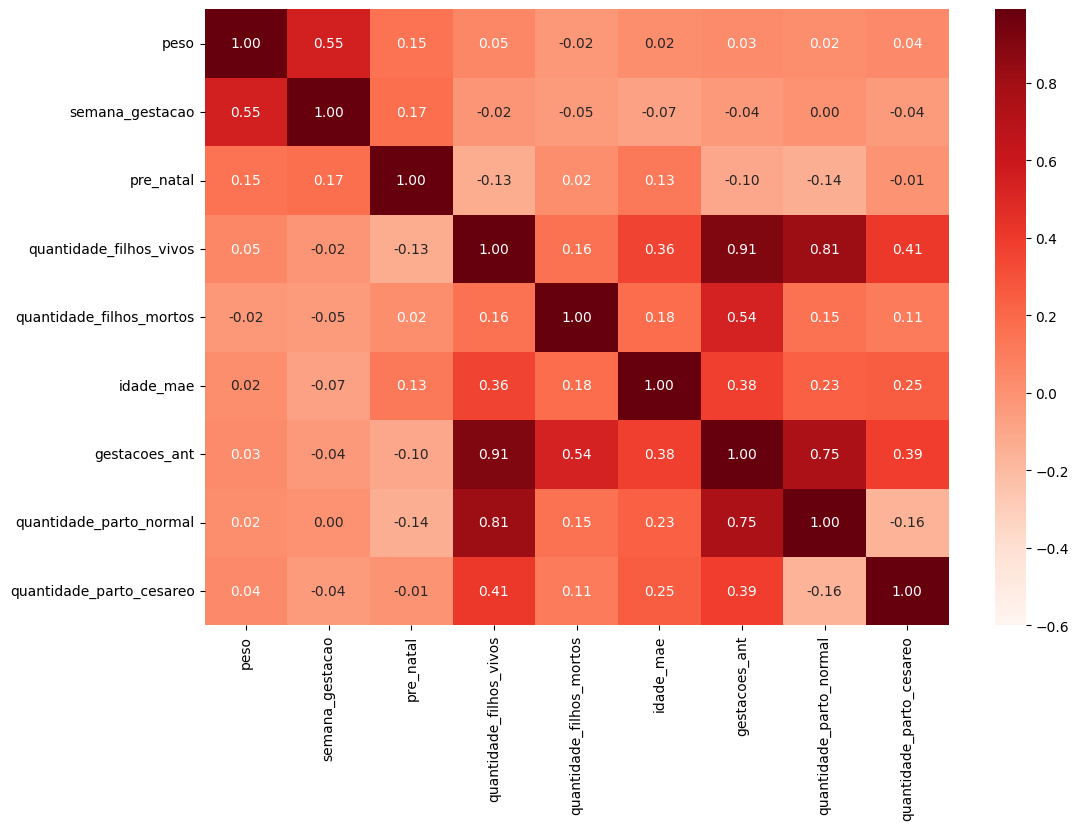

In [23]:
# Visualização por mapa de calor
# Tamanho da figura
plt.figure(figsize = (12,8))

# Mapa de calor
# Estamos realçando os valores de correlação entre 0.59 e 0.99, positivo ou negativo.
sns.heatmap(dados_peso.corr(), annot = True, fmt = '.2f', cmap = 'Reds', vmax = .99, vmin = -0.60)
plt.show()

O mapa de calor da correlação de Pearson nos traz dois insights principais:

- **Fatores Relevantes:** As variáveis semana_gestacao (0.55) e pre_natal (0.15) apresentam a maior correlação positiva com o peso.

- **Alerta de Multicolinearidade:** Existe uma correlação altíssima (>0.75) entre o grupo de variáveis: gestacoes_ant, quantidade_filhos_vivos e quantidade_parto_normal. Elas são redundantes e não devem ser usadas juntas em um modelo de regressão linear. Com base nisso, o projeto seguirá apenas com as variáveis independentes.

## Análise bivariada para confirmar multicolinearidade

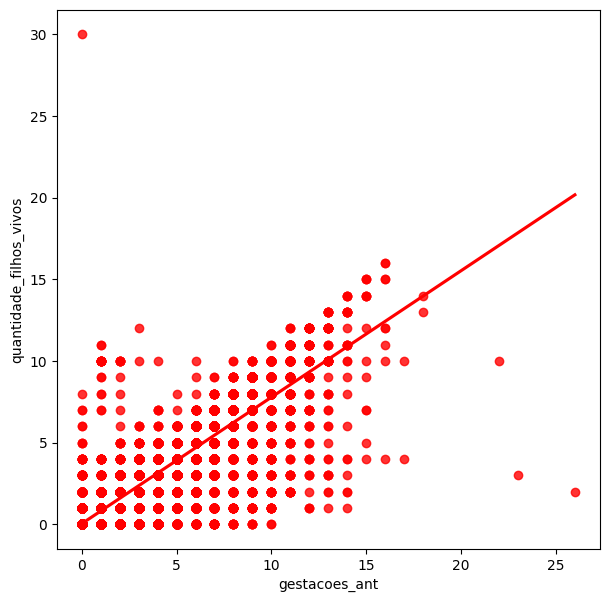

In [24]:
# gestacoes_ant vs quantidade_filhos_vivos
plt.figure(figsize = (7, 7))
sns.regplot(x = 'gestacoes_ant', y = 'quantidade_filhos_vivos', data = dados_peso, color = 'red')
plt.show()

In [25]:
# Coeficiente de Correlação
print('A Correlação entre as variáveis é:', pearsonr(dados['gestacoes_ant'],
                                                     dados['quantidade_filhos_vivos'])[0])

A Correlação entre as variáveis é: 0.9081688161773245


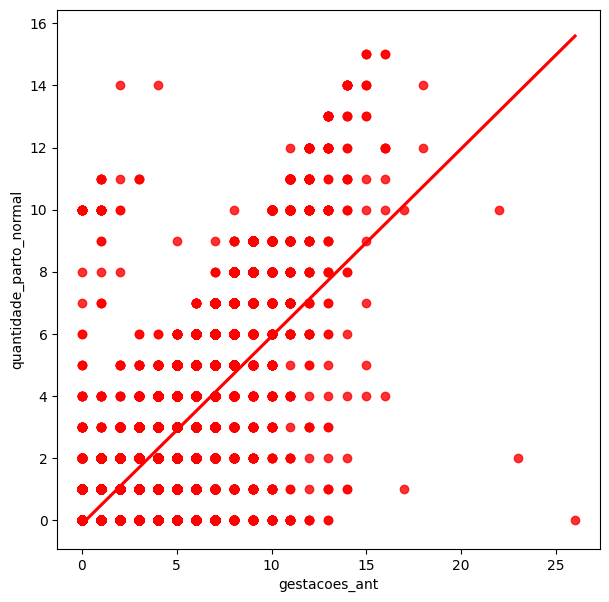

In [26]:
# gestacoes_ant vs quantidade_parto_normal
plt.figure(figsize = (7, 7))
sns.regplot(x = 'gestacoes_ant', y = 'quantidade_parto_normal', data = dados_peso, color = 'red')
plt.show()

In [27]:
# Coeficiente de Correlação
print('A Correlação entre as variáveis é:', pearsonr(dados['gestacoes_ant'],
                                                     dados['quantidade_parto_normal'])[0])

A Correlação entre as variáveis é: 0.7519739558147822


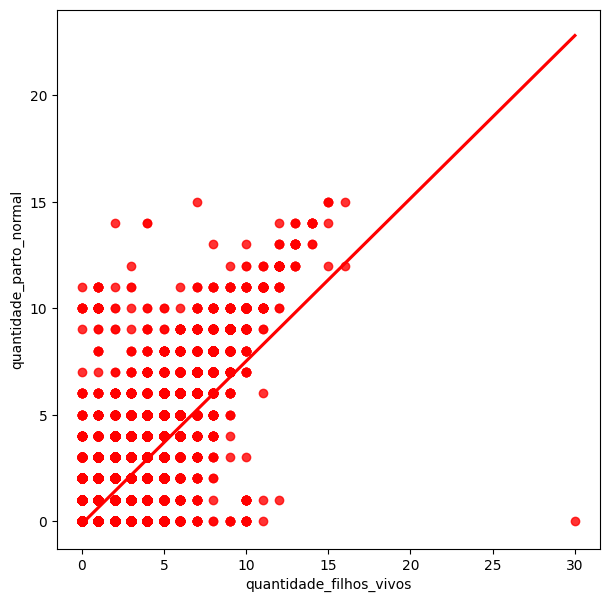

In [28]:
# quantidade_filhos_vivos vs quantidade_parto_normal
plt.figure(figsize = (7, 7))
sns.regplot(x = 'quantidade_filhos_vivos', y = 'quantidade_parto_normal', data = dados_peso, color = 'red')
plt.show()

In [31]:
# Coeficiente de Correlação
print('A Correlação entre as variáveis é:', pearsonr(dados['quantidade_filhos_vivos'],
                                                     dados['quantidade_parto_normal'])[0])

A Correlação entre as variáveis é: 0.8111011433817984


Os diagramas de disperssão reforçam a suposição de multicolinearidade entre as variáveis **gestacoes_ant**, **quantidade_filhos_vivos** e **quantidade_parto_normal**.

Com base no que foi analisado até aqui, seguiremos com as variáveis abaixo para explicar o peso

- idade_mae
- quantidade_filhos_mortos
- pre_natal
- quantidade_parto_cesareo

## Preparação para a Modelagem (Pré-processamento)

In [32]:
# Definindo o dataframe com as variáveis que apresentaram correlação com a variável alvo
colunas_excluir_final = [
    'quantidade_filhos_vivos',
    'gestacoes_ant',
    'quantidade_parto_normal'
    ]

df_peso_final = dados_peso.drop(columns=colunas_excluir_final)

for coluna in df_peso_final.columns:
    # A conversão aqui é o passo crucial
    if df_peso_final[coluna].dtype == 'Int64':
        df_peso_final[coluna] = df_peso_final[coluna].astype('int64')

In [33]:
# Separando as variáveis
Y = df_peso_final['peso']
X = df_peso_final.drop(columns = {'peso'})

In [34]:
# Divide os dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.20 , random_state = 1)

In [35]:
# --- 3. PADRONIZAÇÃO (O Passo Chave) ---
# Inicializa o padronizador
scaler = StandardScaler()

# Aprende a média e o desvio padrão com os dados de TREINO e os transforma
X_treino_padronizado = scaler.fit_transform(X_treino)

# Usa a MESMA transformação aprendida para transformar os dados de TESTE
X_teste_padronizado = scaler.transform(X_teste)

# --- 4. Treinar o Modelo com os Dados Padronizados ---
modelo_padronizado = LinearRegression()
modelo_padronizado.fit(X_treino_padronizado, y_treino)

# --- 5. Avaliar o Modelo e Ver os Resultados ---
# Fazendo previsões com os dados de teste padronizados
previsoes = modelo_padronizado.predict(X_teste_padronizado)

## Modelagem estatística

In [36]:
# Adiciona a constante (intercepto)
X_treino_const = sm.add_constant(X_treino_padronizado)

In [37]:
# Cria o modelo
modelo_v1 = sm.OLS(y_treino, X_treino_const).fit()

In [38]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   peso   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                 6.767e+04
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:23:00   Log-Likelihood:            -5.6036e+06
No. Observations:              741783   AIC:                         1.121e+07
Df Residuals:                  741777   BIC:                         1.121e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3154.5777      0.536   5882.403      0.000    3153.527    3155.629
x1           305.1943      0.547    557.789      0.000     304.122     306.267
x2            28.3561      0.550     51.547      0.000      27.278      29.434
x3            -7.4128      0.547    -13.554      0.000      -8.485      -6.341
x4            23.4430      0.568     41.288      0.000      22.330      24.556
x5            32.8553      0.555     59.146      0.000      31.767      33.944
==============================================================================
Omnibus:                    42409.302   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183394.365
Skew:                           0.013   Prob(JB):                         0.00
Kurtosis:                       5.436   Cond. No.                         1.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Análise dos Resultados do Modelo Linear**

A tabela de resultados do modelo OLS (Mínimos Quadrados Ordinários) nos permite fazer um diagnóstico completo:

- **Performance Geral (R²)**: O **R-quadrado de 0.313** indica que nosso modelo consegue explicar **31.3%** da variação no peso dos bebês. Para um fenômeno biológico complexo, este é um resultado razoável e demonstra que as variáveis escolhidas têm poder preditivo real.

- **Significância Estatística**: O **Prob (F-statistic)** próximo de 0.00 mostra que o modelo como um todo é estatisticamente significativo e a relação encontrada não é obra do acaso.

- **Análise dos Coeficientes**:

 - **const (Intercepto): +3154.58 gramas**. Este é o ponto de partida. Um bebê com zero em todas as outras variáveis (o que é teoricamente impossível, mas é a base matemática) teria um peso previsto de aproximadamente 3155 gramas.

 - **x1 (semana_gestacao): +305.19 gramas**: Este é, de longe, **o fator mais influente.** Para cada semana a mais de gestação, o peso do bebê tende a aumentar, em média, **305 gramas**. Isso faz total sentido clínico e confirma que a maturidade gestacional é o principal preditor do peso.

  - **x2 (pre_natal): +28.36 gramas**: Cada consulta de pré-natal a mais está associada a um aumento médio de **28 gramas** no peso do bebê. É um impacto positivo e estatisticamente significativo, reforçando a importância do acompanhamento médico.

  - **x3 (quantidade_filhos_mortos): -7.41 gramas**: Esta variável tem um impacto negativo. Cada registro de filho morto anterior está associado a uma diminuição média de **7.4 gramas** no peso do bebê atual. Isso pode ser um indicador de condições de saúde materna ou histórico de gestações de risco.

  - **x4 (idade_mae): +23.44 gramas**: Para cada ano a mais na idade da mãe, o peso do bebê tende a aumentar, em média, **23 gramas**.

  - **x5 (quantidade_parto_cesareo): +32.86 gramas**: Cada parto cesáreo anterior está associado a um aumento médio de **33 gramas** no peso do bebê.

- **Diagnóstico do Modelo**: O Cond. No. de 1.43 é muito baixo, indicando que não temos problemas de multicolinearidade. A única ressalva é a Kurtosis de 5.436, que sugere que o modelo tem dificuldade em prever os casos mais extremos (bebês muito leves ou muito pesados), o que é esperado.

**Conclusão da Modelagem**

O modelo de regressão linear, que explica 31.3% da variação do peso ao nascer, demonstrou que todas as variáveis selecionadas são preditores estatisticamente significativos. A **semana de gestação** emergiu como o fator de influência predominante, com um impacto positivo massivo. Fatores como o **histórico de partos cesáreos, número de consultas pré-natal e a idade da mãe** também contribuem positivamente para o aumento do peso, enquanto o histórico de filhos mortos tem um leve impacto negativo.